# Result evaluation
Now that we have all the results stored in 'logs' we can compute the numerical statistics we desire over them. Our objectives are to compute the confidence intervals for each of methods and compare them. Also we want to plot the cummulative reward for the best agents of each method and plot them.

In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

In [2]:
# define functions to extract the results
def read_json(filename):
    """Given a filename, return its contents as a pandas dataframe"""
    with open(filename) as f:
        return pd.DataFrame(json.loads(f.read()))
    
def get_jsons(mypath):
    """Returns the files in a directory"""
    return [f for f in listdir(mypath) if isfile(join(mypath, f)) and f.endswith('json')]


def get_results():
    """Return the results as pandas dataframe"""
    dataframes = []
    for json_file in get_jsons('logs'):
        dataframe = read_json(join('logs', json_file))
        dataframe['file'] = json_file
        
        # split the filename into (experiment, run)
        experiment_name, _ = json_file.split('.')
        run_nb = experiment_name.split('_')[-1]
        model_name = experiment_name[:-len(run_nb)-1]
        
        # add them to the dataframe
        dataframe['model'] = model_name
        dataframe['run_nb'] = run_nb
        
        dataframes.append(dataframe)
    return pd.concat(dataframes)


# get the results in a dataframe
results = get_results()

In [3]:
# get the best results for each run
best_episode_reward_by_file = results.sort_values('episode_reward', ascending=False).groupby('file').first()
best_episode_reward_by_file.head()

,duration,episode,episode_reward,loss,mean_absolute_error,mean_eps,mean_q,model,nb_episode_steps,nb_steps,run_nb
file,,,,,,,,,,,
double_dqn_0.json,34.166530,287,2.693346e+05,79208.062500,9109.014648,NaN,9798.021484,double_dqn,3194,89563,0
double_dqn_1.json,39.395238,375,2.545978e+05,82502.257812,6725.333496,NaN,7354.654297,double_dqn,3548,54715,1
double_dqn_2.json,24.584379,344,1.877360e+05,75212.148438,6795.981445,NaN,7357.500977,double_dqn,2140,96238,2
double_dqn_3.json,36.032177,278,3.451130e+05,259817.078125,12597.678711,NaN,13814.849609,double_dqn,3076,67533,3
double_dqn_4.json,195.377221,239,1.082600e+06,87326.851562,10919.737305,NaN,11799.360352,double_dqn,17726,91996,4


## Confidence intervals
Compute the confidence intervals for each of the models' maximum rewards. 10 training runs might not reflect the values perfectly but it's sufficient as a proof-of-concept.

In [4]:
def get_confidence_interval(sample, confidence=0.95):
    """Given a series of values, return the mean and margin of error(using t-test)"""
    sample_size = len(sample)
    sample_mean = sample.mean()

    t_critical = stats.t.ppf(q=confidence, df=sample_size-1)  # Get the t-critical value*                       
    sample_stdev = sample.std()    # Get the sample standard deviation

    sigma = sample_stdev/np.sqrt(sample_size)  # Standard deviation estimate
    margin_of_error = t_critical * sigma
    
    return pd.Series({'mean': sample_mean, 'margin_of_error': margin_of_error})

### Best episode for each for the models

In [5]:
# best episode per run, for each modeltype with a margin of error
best_episode_reward_by_file.groupby('model')['episode_reward'].apply(get_confidence_interval).unstack()

,margin_of_error,mean
model,,
double_dqn,181772.282729,470631.071975
dueling_dqn,115380.463455,295201.681357
simple_dqn,157180.135173,458265.912672
simple_dqn_boltzmann,1824.164430,8462.247526
simple_dqn_linear_eps,261283.204166,500830.456806


Compute the cumsum for rewards. Also add the mean reward

In [6]:
results['cummulative_reward'] = results.groupby('file')['episode_reward'].cumsum()
results['mean_reward'] = results['episode_reward'] / results['nb_episode_steps']

### Mean reward for each of the models

In [7]:
# 
best_mean_reward_by_file = results.sort_values('cummulative_reward', ascending=False).groupby('file').first()
best_mean_reward_by_file['overall_mean_reward'] = best_mean_reward_by_file['cummulative_reward'] / 100000

best_mean_reward_by_file.groupby('model')['overall_mean_reward'].apply(get_confidence_interval).unstack()

,margin_of_error,mean
model,,
double_dqn,8.612427,58.534689
dueling_dqn,7.349089,50.938470
simple_dqn,10.224843,56.257733
simple_dqn_boltzmann,0.224812,1.594884
simple_dqn_linear_eps,12.118506,30.103519


In [8]:
# get the runs that yielded the best results for each of the models
best_file_per_model = best_episode_reward_by_file.reset_index().sort_values('episode_reward', ascending=False).groupby('model').first()['file']
best_file_per_model
# get the dataframe with result for the runs with the best episode grouped by model
best_per_model = results[results['file'].isin(best_file_per_model)].set_index('model')
best_per_model.head()

,duration,episode,episode_reward,file,loss,mean_absolute_error,mean_eps,mean_q,nb_episode_steps,nb_steps,run_nb,cummulative_reward,mean_reward
model,,,,,,,,,,,,,
double_dqn,15.067137,0,3779.332295,double_dqn_4.json,NaN,NaN,NaN,NaN,292,292,4,3779.332295,12.942919
double_dqn,0.891167,1,1821.294233,double_dqn_4.json,NaN,NaN,NaN,NaN,158,450,4,5600.626528,11.527179
double_dqn,4.229616,2,7624.834781,double_dqn_4.json,NaN,NaN,NaN,NaN,573,1023,4,13225.461308,13.306867
double_dqn,3.125115,3,7685.295853,double_dqn_4.json,NaN,NaN,NaN,NaN,560,1583,4,20910.757161,13.723743
double_dqn,3.231437,4,7677.685776,double_dqn_4.json,NaN,NaN,NaN,NaN,576,2159,4,28588.442937,13.329316


In [9]:
# get the runs that yielded the best results for each of the models
best_file_per_model_mean = best_mean_reward_by_file.reset_index().sort_values('overall_mean_reward', ascending=False).groupby('model').first()['file']

best_mean_per_model = results[results['file'].isin(best_file_per_model_mean)].set_index('model')
best_mean_per_model.head()

,duration,episode,episode_reward,file,loss,mean_absolute_error,mean_eps,mean_q,nb_episode_steps,nb_steps,run_nb,cummulative_reward,mean_reward
model,,,,,,,,,,,,,
double_dqn,15.268145,0,1262.244159,double_dqn_3.json,NaN,NaN,NaN,NaN,397,397,3,1262.244159,3.179456
double_dqn,2.776207,1,-525.068456,double_dqn_3.json,NaN,NaN,NaN,NaN,502,899,3,737.175703,-1.045953
double_dqn,3.992564,2,586.860561,double_dqn_3.json,NaN,NaN,NaN,NaN,543,1442,3,1324.036265,1.080775
double_dqn,3.957755,3,2431.102645,double_dqn_3.json,NaN,NaN,NaN,NaN,530,1972,3,3755.138910,4.586986
double_dqn,2.780887,4,-24.271167,double_dqn_3.json,NaN,NaN,NaN,NaN,502,2474,3,3730.867743,-0.048349


## Plotting
We will be plotting the cumulative reward curve for both policies and architectures

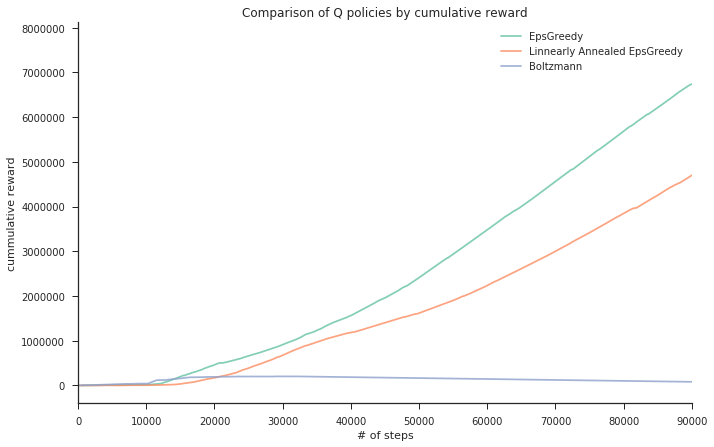

In [10]:
model_name_map = {
    'simple_dqn': 'EpsGreedy',
    'simple_dqn_linear_eps': 'Linnearly Annealed EpsGreedy',
    'simple_dqn_boltzmann': 'Boltzmann'
}

fig, ax = plt.subplots(figsize=(11, 7))

for model, label in model_name_map.items():
    best_mean_per_model.loc[model].plot(x='nb_steps', y='cummulative_reward', 
                                                     ax=ax, alpha=0.8, label=label)

plt.title('Comparison of Q policies by cumulative reward')
plt.legend()
plt.xlabel('# of steps')
plt.ylabel('cummulative reward')
plt.xlim(0, 9e4)
sns.despine(fig=fig, ax=ax)

# also save it 
fig.savefig('figures/policies.png', dpi=200)

And now by architecture

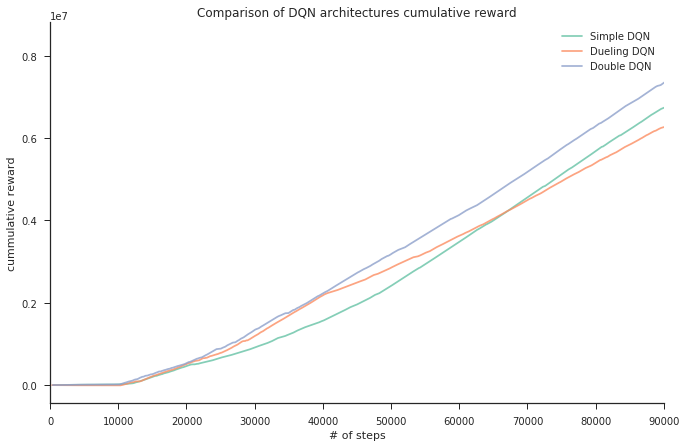

In [11]:
model_name_map = {
    'simple_dqn': 'Simple DQN',
    'dueling_dqn': 'Dueling DQN',
    'double_dqn': 'Double DQN'
}

fig, ax = plt.subplots(figsize=(11, 7))

for model, label in model_name_map.items():
    best_mean_per_model.loc[model].plot(x='nb_steps', y='cummulative_reward', 
                                                     ax=ax, alpha=0.8, label=label)

plt.title('Comparison of DQN architectures cumulative reward')
plt.legend()
plt.xlabel('# of steps')
plt.ylabel('cummulative reward')
plt.xlim(0, 9e4)
sns.despine(fig=fig, ax=ax)

# also save it 
fig.savefig('figures/architectures.png', dpi=200)